In [1]:
import os

import numpy as np
import pandas as pd
import torch
import torchvision.transforms as tt
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import DNN_predicter
from sklearn.preprocessing import MinMaxScaler
from scripts.collaborative_recommendations import get_recommendation_collaborative

In [2]:
cwd = os.getcwd()
parent_directory = os.path.abspath(os.path.join(cwd, os.pardir))
data_directory = os.path.join(parent_directory, "data")

Na wejściu dajemy user_id, image_przedmiotu, który został zarekomendowany przez collaborative reccomender. Dostajemy prawdopodobieństwo, że user kupi dany przedmiot. 

In [3]:
df_train = pd.read_json(
    # os.path.join(data_directory, "reviews_sentiment_train.json"), orient="split"
    os.path.join(data_directory, "limited_10_3_sweaters_reviews_sentiment_train.json"),
    orient="split",
)
melted_df_train = pd.melt(
    df_train.reset_index(), id_vars="index", value_vars=df_train.columns
)
melted_df_train.columns = ["user_id", "item_id", "sentiment"]
melted_df_train = melted_df_train[melted_df_train["sentiment"] != -1].reset_index(
    drop=True
)
df_test = pd.read_json(
    os.path.join(data_directory, "limited_10_3_sweaters_reviews_sentiment_test.json"),
    orient="split",
)
melted_df_test = pd.melt(
    df_test.reset_index(), id_vars="index", value_vars=df_test.columns
)
melted_df_test.columns = ["user_id", "item_id", "sentiment"]
melted_df_test = melted_df_test[melted_df_test["sentiment"] != -1].reset_index(
    drop=True
)

scaler = MinMaxScaler(feature_range=(0, 1))
melted_df_test["sentiment"] = scaler.fit_transform(
    melted_df_test.sentiment.values.reshape(-1, 1)
)
recommendations =  get_recommendation_collaborative(df_train, "A2UOWHRPP4895I", 5)
print(recommendations)

Cold start, recommending 5 most popular items
Index(['B00K4AXHF6', 'B00CWDV8VI', 'B00W8LO9RY', 'B00QA8NRLA', 'B00QA89W46'], dtype='object')


In [4]:
users_to_analyze = list(set(df_test.index.unique()) & set(df_train.index.unique()))
df_test = df_test[df_test.index.isin(users_to_analyze)]


In [5]:
pictures_dir = os.path.join(data_directory, "sweater_pics")
image_size = 480
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available!")
else:
    device = torch.device("cpu")
    print("CUDA is not available! Using CPU")

CUDA is available!


Przykład uczący:
-> nazwa użytkownika
-> obrazek, jeśli nie oglądał, to np.zeros_like((imgage_size, image_size))
-> sentyment, przeskalowany do [0, 1]

-> mamy rekomendacje z wyjścia z collaborative
-> dla każdej z rekomendacji przepuszczamy <user_nazwa, image> dostajemy predykcję czy dany użytkownik polubi grę, czy nie
-> sortujemy po predykcji czy grał czy nie i mamy ostateczną rekomendację

In [7]:


scaler = MinMaxScaler(feature_range=(0, 1))
melted_df_train["sentiment"] = scaler.fit_transform(
    melted_df_train.sentiment.values.reshape(-1, 1)
)

In [8]:
melted_df_train.head()

,user_id,item_id,sentiment
0,A28783VQT3U5A5,B0000E014L,0.0
1,A316D2HUYDJV3N,B0000E014L,1.0
2,A3M1YEA00VZM9I,B0000E014L,0.0
3,A2YO4KMBESNQCR,B0006ZLL3Y,0.0
4,A33R9Z36C7TDHC,B000JG677A,1.0


# Creating training data

In [9]:
transform = tt.Compose(
    [
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats),
    ]
)

train_dataset = DNN_predicter.TrainDataset(
    df=melted_df_train,
    pictures_dir=pictures_dir,
    transfrom=transform,
    image_size=image_size,
)
test_dataset = DNN_predicter.TrainDataset(
    df=melted_df_test,
    pictures_dir=pictures_dir,
    transfrom=transform,
    image_size=image_size,
)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
batch_size = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
n_pred_items = 5  # number of items to be recommended
model = DNN_predicter.PredictionModel(
    n_users=df_train.shape[0],
    user_embedding_dim=100,
    picture_embedding_dim=512,
    linear_embedding_dim=300,
    output_pred_dim=1,
    df_train=df_train,
).to(device)

CUDA is available!


Training epoch:   0%|          | 0/15 [00:00<?, ?Epoch/s]

Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.4985085725784302
After epoch mean test acc: 0.0
After epoch mean loss: 0.49619463086128235
After epoch acc: 0.7809835076332092


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.5048834681510925
After epoch mean test acc: 0.0
After epoch mean loss: 0.46351930499076843
After epoch acc: 0.7878464460372925


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.5401606559753418
After epoch mean test acc: 0.0
After epoch mean loss: 0.41956835985183716
After epoch acc: 0.799440324306488


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.5754389762878418
After epoch mean test acc: 0.0
After epoch mean loss: 0.38330593705177307
After epoch acc: 0.8022388219833374


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.6198124289512634
After epoch mean test acc: 0.0
After epoch mean loss: 0.3546127676963806
After epoch acc: 0.808635413646698


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.6718748807907104
After epoch mean test acc: 0.0
After epoch mean loss: 0.34225550293922424
After epoch acc: 0.8128331899642944


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.6255248188972473
After epoch mean test acc: 0.0
After epoch mean loss: 0.32658180594444275
After epoch acc: 0.8206290006637573


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.7763434648513794
After epoch mean test acc: 0.0
After epoch mean loss: 0.3123416006565094
After epoch acc: 0.829291045665741


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.7205005884170532
After epoch mean test acc: 0.0
After epoch mean loss: 0.30977731943130493
After epoch acc: 0.8258928656578064


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.8207182884216309
After epoch mean test acc: 0.0
After epoch mean loss: 0.2951021194458008
After epoch acc: 0.8286914229393005


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.8271710276603699
After epoch mean test acc: 0.0
After epoch mean loss: 0.28769651055336
After epoch acc: 0.8403518199920654


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.8277668952941895
After epoch mean test acc: 0.0
After epoch mean loss: 0.2874317765235901
After epoch acc: 0.8328891396522522


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.855617880821228
After epoch mean test acc: 0.0
After epoch mean loss: 0.28112325072288513
After epoch acc: 0.8394190073013306


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.9025090932846069
After epoch mean test acc: 0.0
After epoch mean loss: 0.2639327049255371
After epoch acc: 0.8478145599365234


Training batch:   0%|          | 0/134 [00:00<?, ?Batch/s]

Testing:   0%|          | 0/34 [00:00<?, ?Batch/s]

After epoch mean test loss: 0.9011984467506409
After epoch mean test acc: 0.0
After epoch mean loss: 0.2622416317462921
After epoch acc: 0.8468816876411438


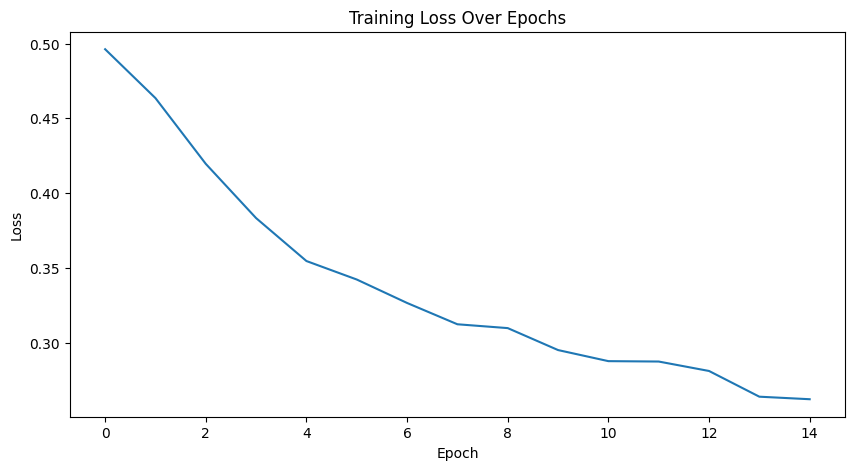

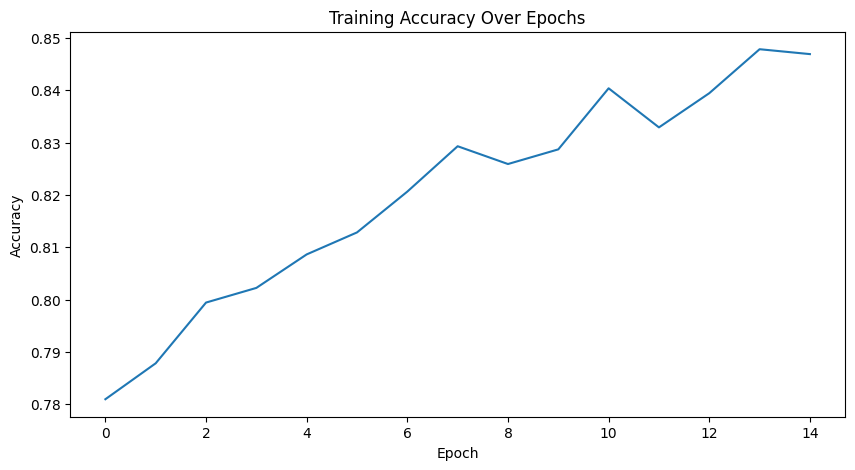

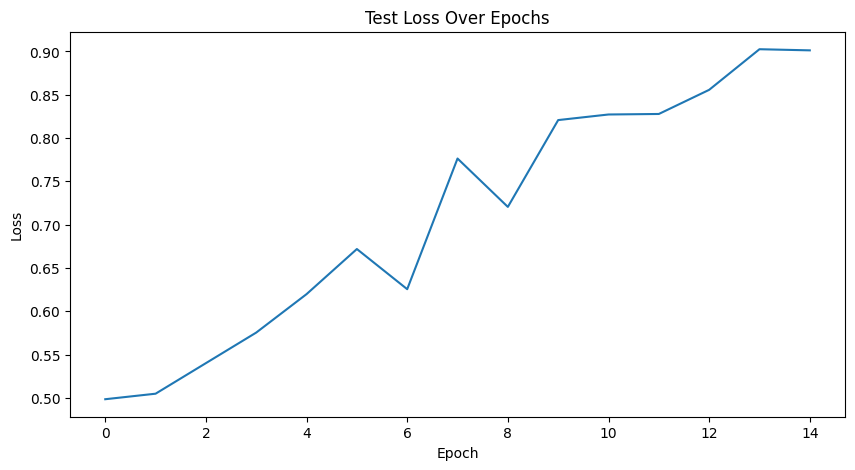

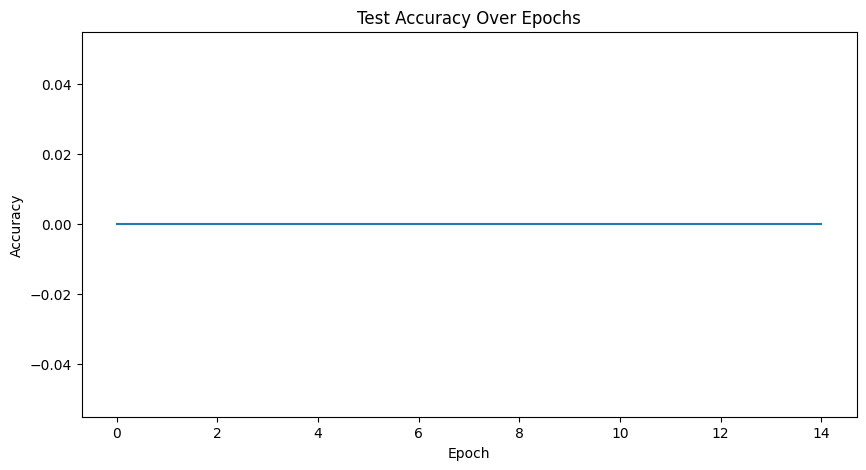

In [11]:
n_epochs = 15
lr = 0.001
loss_model, acc_model = DNN_predicter.fit(
    model=model, train_dl=train_loader, n_epochs=n_epochs, lr=lr, test_dl=test_loader
)

# Simple evaluation for user "A103Y1M1F27V4C"

In [ ]:
model.eval()
model = model.cpu()

In [ ]:
recommendations = get_recommendation_collaborative(
    df_train, "A103Y1M1F27V4C", n_pred_items
)

In [ ]:
user_index = model.df_train.index.get_loc("A103Y1M1F27V4C")

In [ ]:
items_images = {}
for item_name in recommendations:
    dict_path = os.path.join(pictures_dir, item_name)
    images = os.listdir(dict_path)
    if images:
        image_path = os.path.join(dict_path, images[0])
        image = Image.open(image_path)
    else:
        image = Image.fromarray(np.zeros((image_size, image_size, 3), dtype=np.uint8))
    image = transform(image)
    items_images[item_name] = image

In [15]:
user_embedding = model.user_embeddings(torch.tensor(user_index))

In [16]:
predictions = {}
for item_name, image in items_images.items():
    pred = (
        model(torch.tensor(user_index).unsqueeze(0), image.unsqueeze(0)).detach().item()
    )
    predictions[item_name] = pred

In [17]:
predictions

{'B00K4AXHF6': 0.9879337549209595,
 'B00CWDV8VI': 0.9421641826629639,
 'B009FVA5XM': 0.6454722881317139,
 'B00GA84BSI': 0.9778617024421692,
 'B0073ARU5I': 0.9377362728118896}

In [18]:
sorted_items = sorted(predictions.items(), reverse=True, key=lambda item: item[1])

# New reccomendations for user

In [19]:
for idx, tpl in enumerate(sorted_items):
    item_name, pred = tpl
    print(f"{idx+1}. {item_name}")

1. B00K4AXHF6
2. B00GA84BSI
3. B00CWDV8VI
4. B0073ARU5I
5. B009FVA5XM


# Before DNN model.

In [20]:
for idx, item_name in enumerate(recommendations):
    print(f"{idx+1}. {item_name}")

1. B00K4AXHF6
2. B00CWDV8VI
3. B009FVA5XM
4. B00GA84BSI
5. B0073ARU5I
